## Sensitivity Analysis

Author: Yudong Li

Contact: Yudong.Li@nrel.gov

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from g2t.core.glucose_reactions_packedbed import get_rxn_rates_pkb 
from g2t.core.constants import *
from scikits.odes.odeint import odeint
from scipy import integrate as igt
from g2t.core.species import *
from g2t import get_rxn_rates, EnzymeSystem

import numpy as np
import matplotlib.pyplot as plt

from g2t.core.enzyme_kinetics import *
import pandas as pd

from sensitivity_analysis import run_sa, run_cofactor_sa

In [3]:
plt.rc('font', family='sans-serif', serif='Arial', size = 14)
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)

In [4]:
# initial limonene production
c0 = np.zeros(TOTAL_SPECIES)
c0[Glc] = 100
c0[ADP] = 2
c0[ATP] = 2
c0[FBP] = 1
c0[P_I] = 10
c0[NAD] = 0.5
c0[NADP] = 1.5
c0[PPi] = 0.5 # from Thiamine pyrophosphate
c0[CoA] = 1.5
c0[BPG13] = 0.25
# glutathione 5mM

In [5]:
"""
# CoPASI
def Vmax_rhs(t, y, ydot):
    get_rxn_rates(y, ydot)

enzSys = EnzymeSystem(fitExp=False)
def kcat_rhs(t, y, ydot):
    enzSys.get_rate(y, ydot)
"""

# experiment
enzSys = EnzymeSystem(fitExp=True)
def kcat_rhs(t, y, ydot): # this is the experiment
    enzSys.get_rate(y, ydot)

In [12]:
enzSys.enzymes['Pyk'].Kcat

370000.0

In [44]:
# start with these Kcats


# fit_again = {
#     'Hex': 49615.3784209611, 'NoxE': 1136.3479611885175, 'PPase': 2206.3524049873267,
# }
# for k, v in fit_again.items():
#     enzSys.set_enzyme_Kcat(k, v)

# 1 OoM = Hex, Gap, NoxE, PPase
# 2 OoM = Pgi, Pfk, Fba, Tpi, mGap, Pgk, Eno, Pyk, PhaA, 
# as long as Hex, NoxE, PPase specified, matches exp results

In [6]:
"""
# CoPASI
extra_options = {'old_api': False, 'rtol': 1e-6, 'atol': 1e-12, 'max_steps': 50000}
solution = odeint(kcat_rhs, np.linspace(0, 60*60*6, 1000), c0, method='bdf', **extra_options)

# solver_method = 'cvode'
# extra_options = {'old_api': False, 'rtol': 1e-6, 'atol': 1e-12, 'max_steps': 50000}
# times = np.linspace(0, 3600*6, 10000)
# solver = ode(solver_method, rhs, **extra_options)
# solution = solver.solve(times, c0)
"""

# experiment
extra_options = {'old_api': False, 'rtol': 1e-6, 'atol': 1e-12, 'max_steps': 50000}
solution = odeint(kcat_rhs, np.linspace(0, 60*60*24*6, 1000), c0, method='bdf', **extra_options)

time = solution.values.t
c = solution.values.y

pgi = Pgi(packedBed=False)
N = len(time)
carbon = np.zeros(N)
P = np.zeros(N) 
rate_pgi = np.zeros(N)
for i in range(N):
    carbon[i] = total_carbon(c[i, :])
    P[i] = total_P(c[i,:])
    rate_pgi[i] = pgi.get_rate(c[i, G6P], c[i, F6P])

In [7]:
# import excel document to plot experimental results
expdata = {}
expdata["Experimental Data"] = pd.read_excel("GlcToLim_expData.xlsx", sheet_name=0)

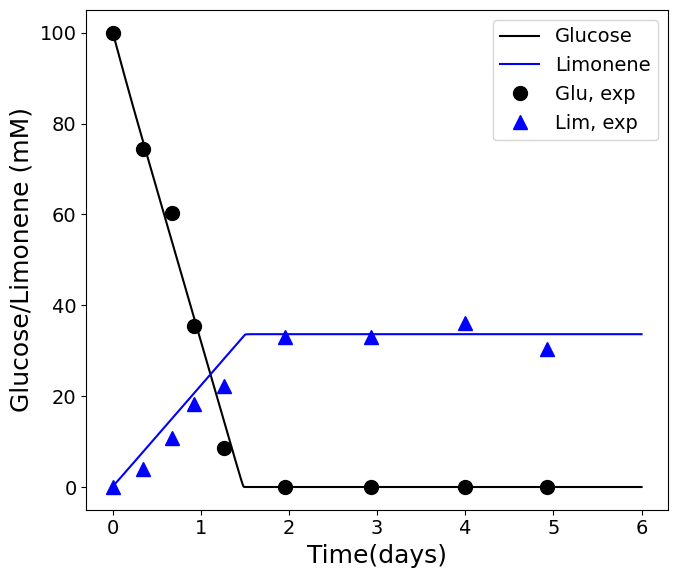

In [11]:
fig= plt.figure(figsize=(7, 6))
ax1 = fig.subplots()

ax1.set_xlabel("Time(days)")
ax1.set_ylabel("Glucose/Limonene (mM)")
"""
# CoPASI
ax1.plot(time/3600, c[:, Glc], label="Glucose")
ax1.plot(time/3600, c[:, LIM], label="Limonene")
#ax1.plot(time/3600, carbon, label="total carbon")
#ax1.plot(time/3600, P, label="total P")
# ax1.plot(time/3600, rate_pgi, label="rate Pgi")
"""

# experiment
ax1.plot(time/(3600*24), c[:, Glc],c='k', label="Glucose")
ax1.plot(time/(3600*24), c[:, LIM],c='b', label="Limonene")

# plot experimental data fig 4a
for key,val in expdata.items():
    ax1.plot(val["Time(s)"]/(3600*24),val["Glc(mM)"], 'o', markersize=10, c='k', label="Glu, exp")
    ax1.plot(val["Time(s)"]/(3600*24),val["Lim(mM)"], '^', markersize=10, c='b', label="Lim, exp")

# for sensitivity param sweep
tt = [1.75,1.75]
cc = [0,100]

ax1.legend(loc = "best")
fig.tight_layout()
plt.savefig("ExpValidation.png", dpi=300, bbox_inches="tight")

In [13]:
from validation import plot_validation_curve

In [15]:
parameters = {'Gap': 105741.11062548366,
  'Hex': 63573.32167325032,
  'NoxE': 4000.0,
  'PPase': 1000.0,
  'Pgk': 154645.4903371387,
  'Pyk': 42006.410265136714,
  'Tpi': 60384.48710220473}

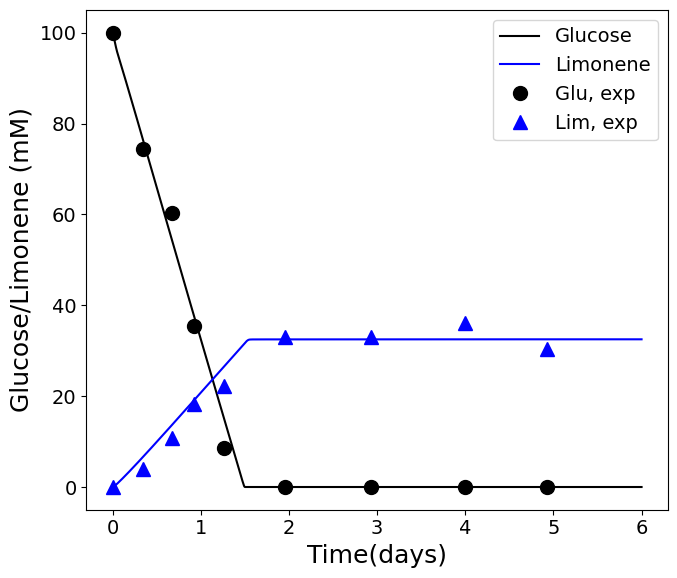

In [16]:
plot_validation_curve(parameters=parameters)

/home/yli5/working/GlucoseToTerpene/demonotebooks/sensitivity_analysis.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig= plt.figure(figsize=(7, 6))


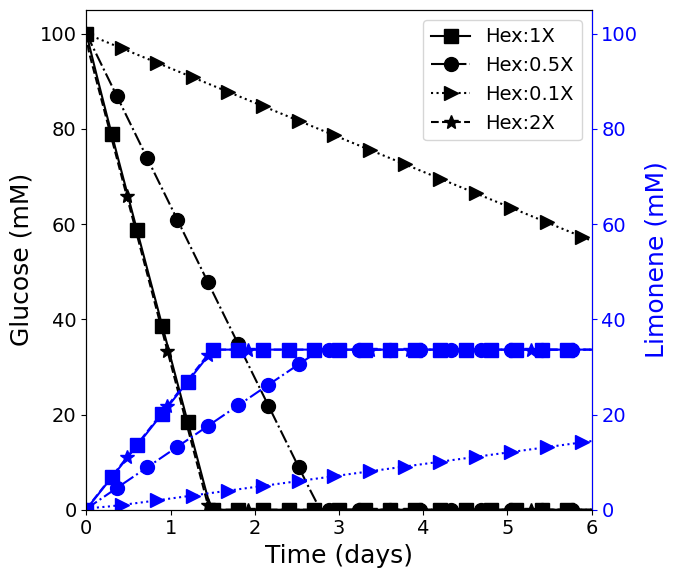

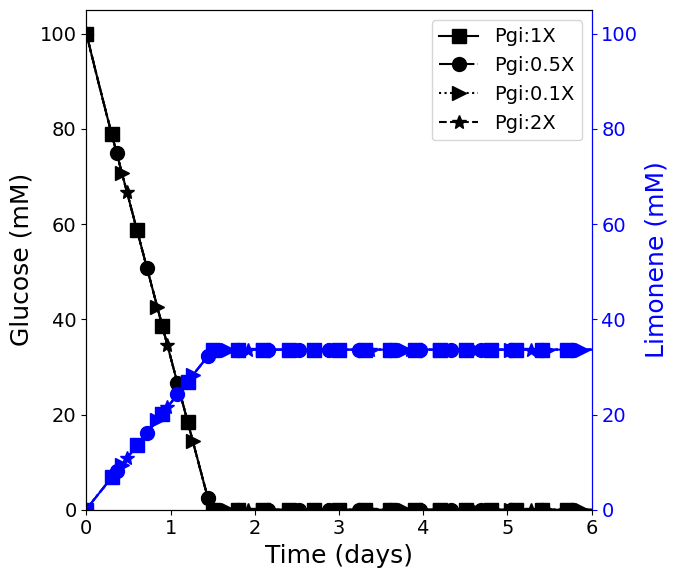

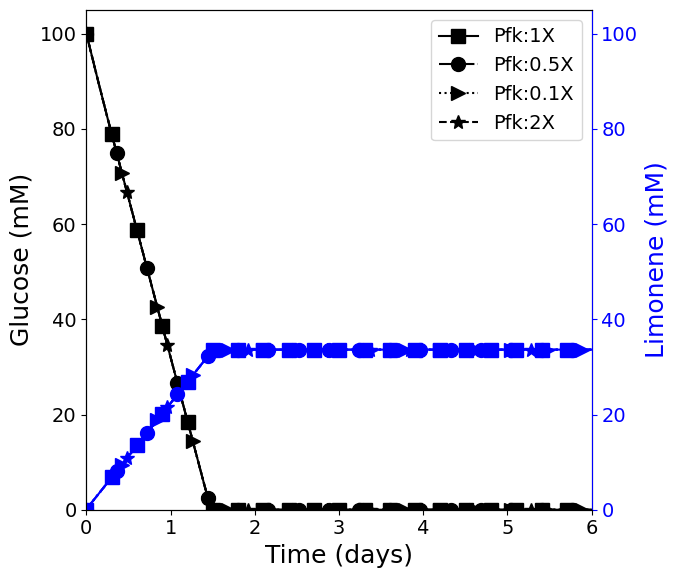

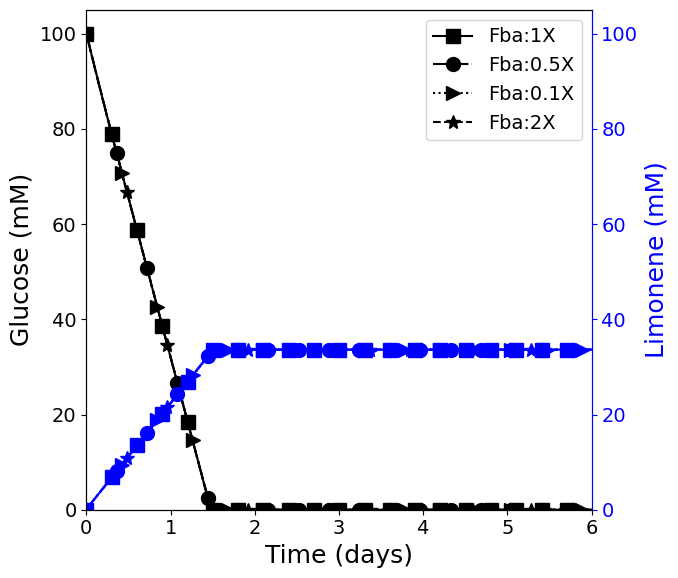

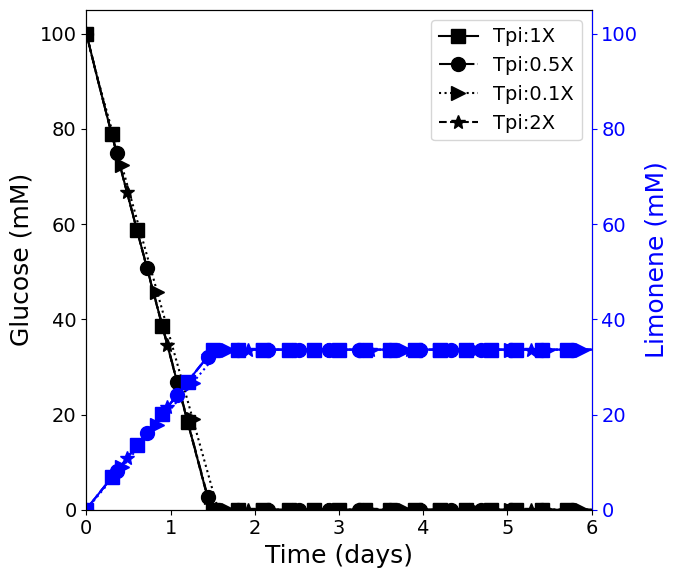

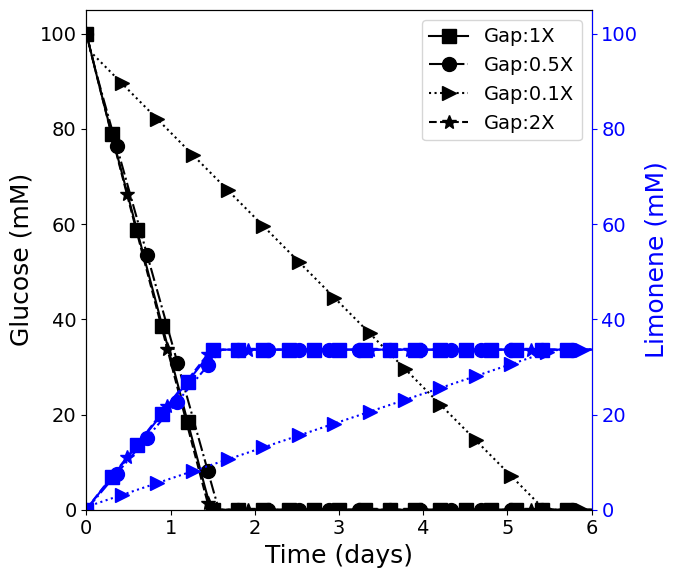

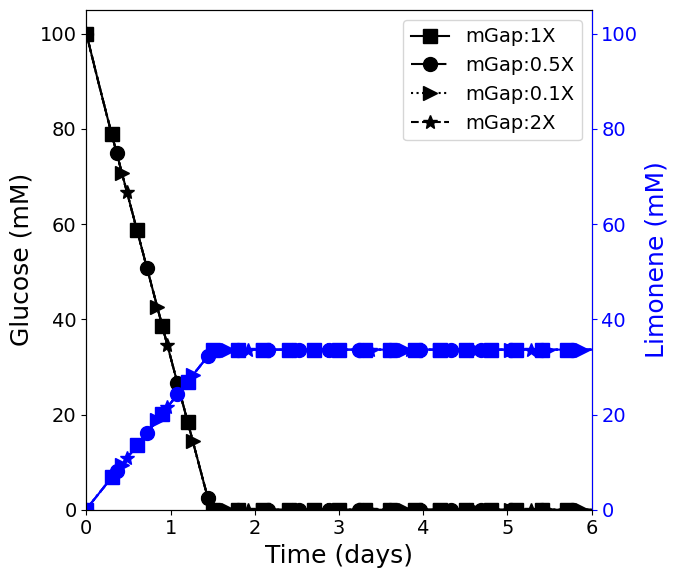

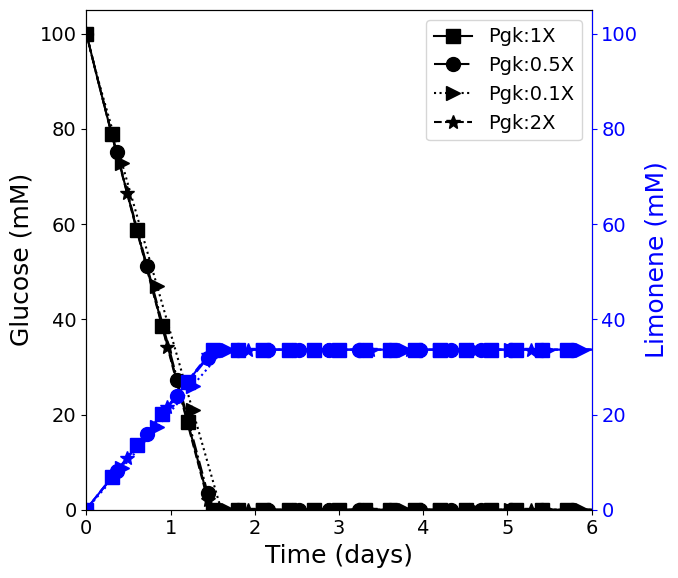

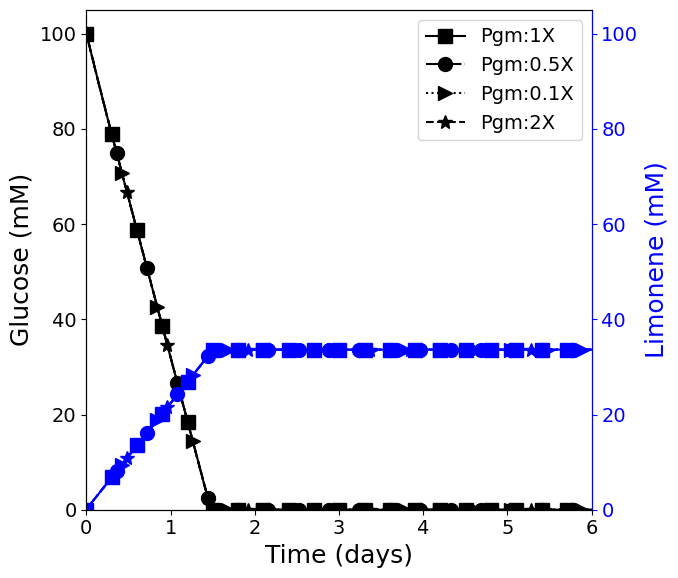

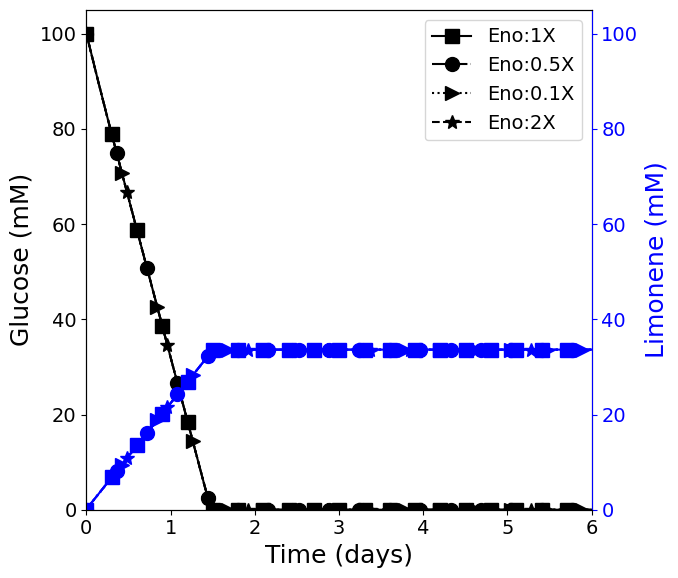

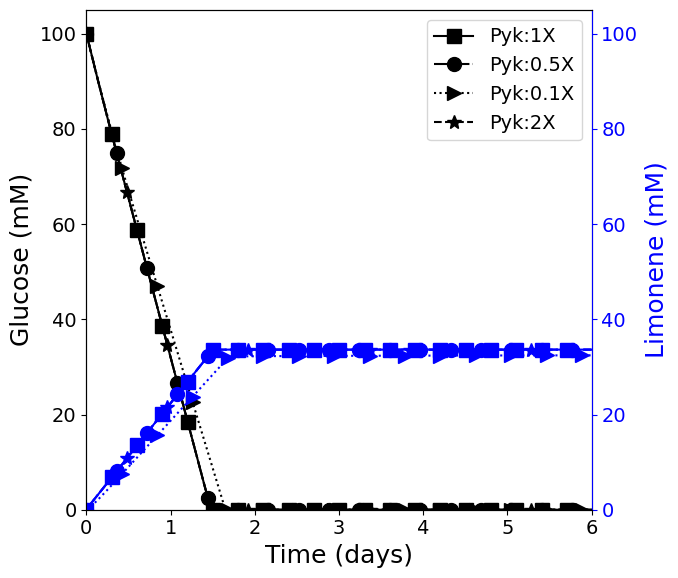

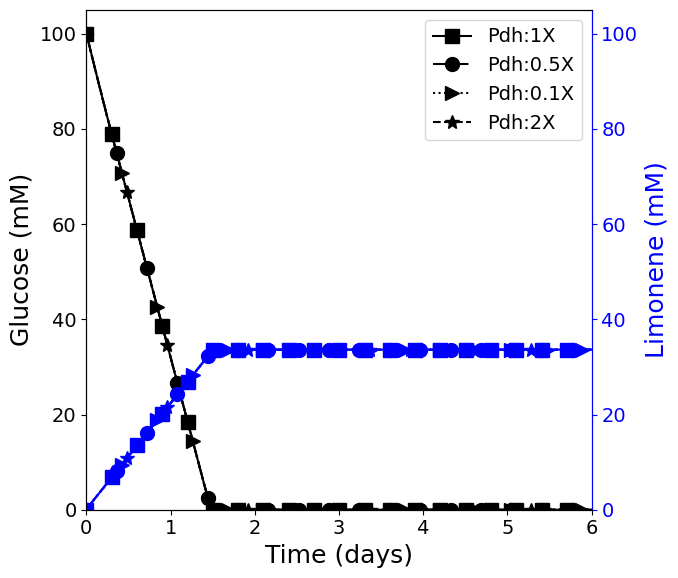

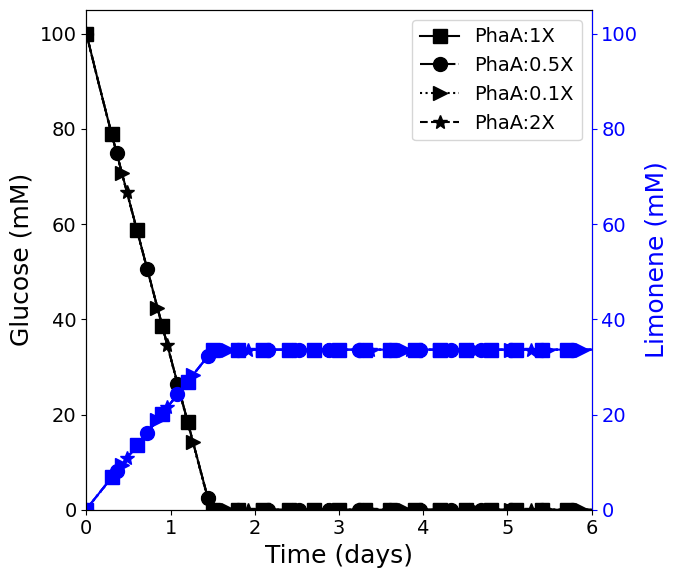

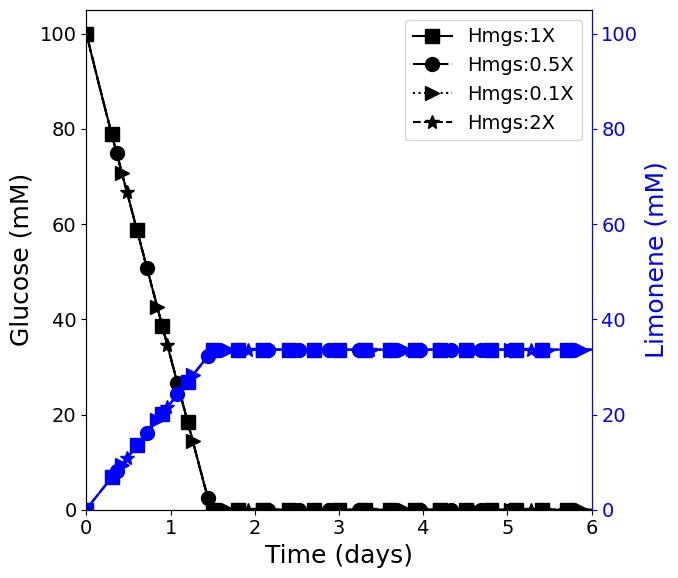

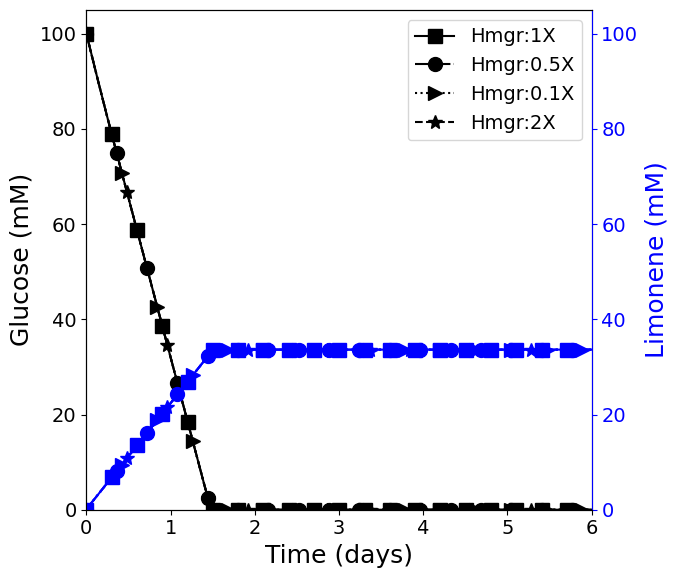

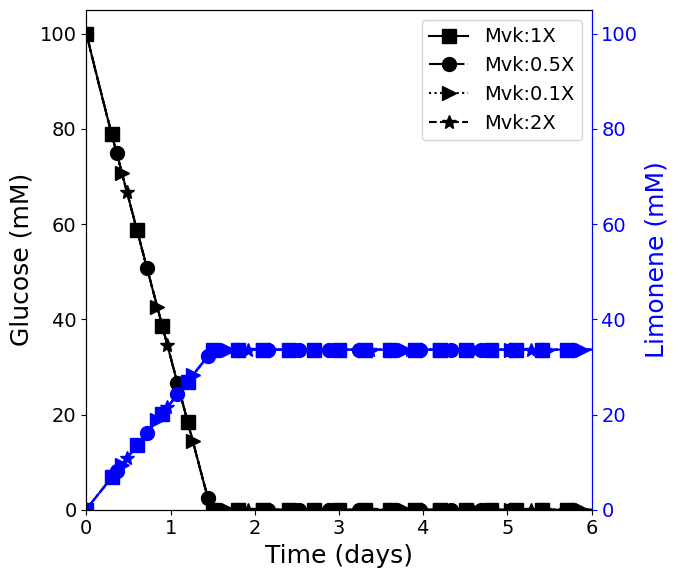

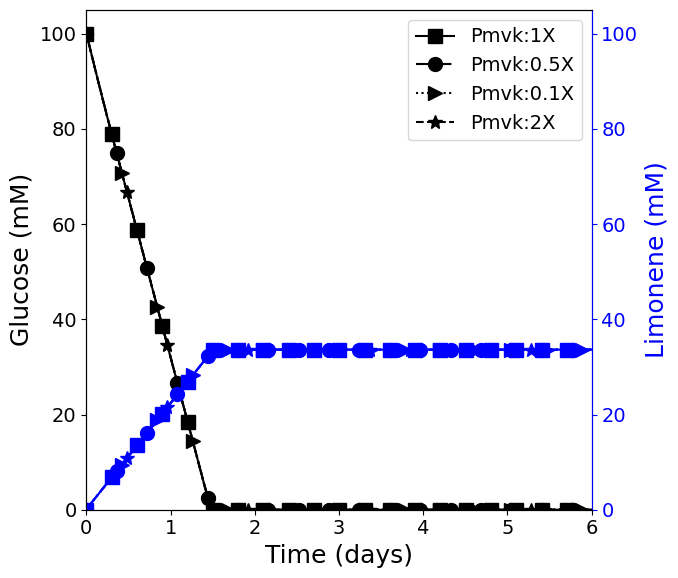

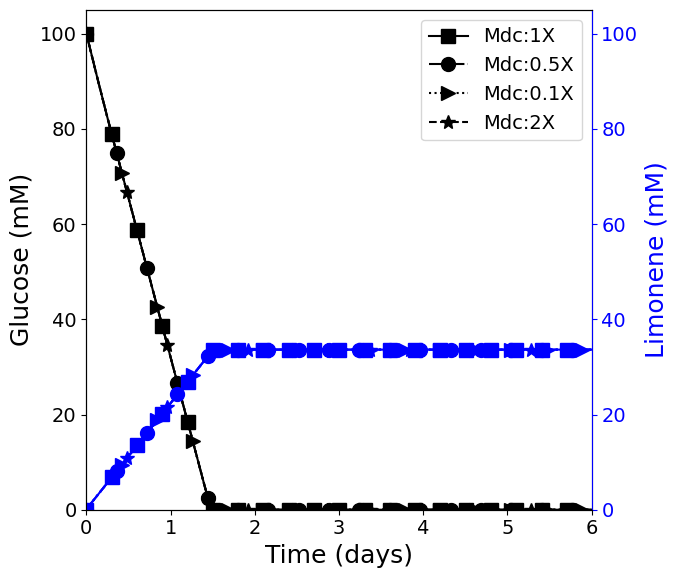

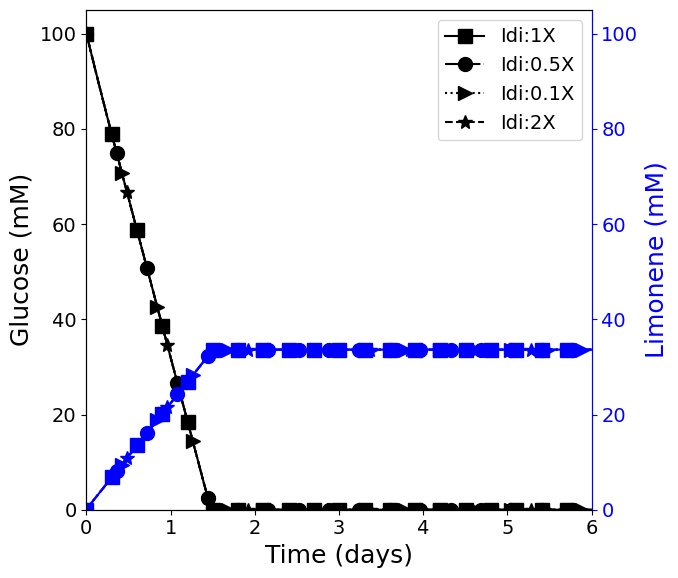

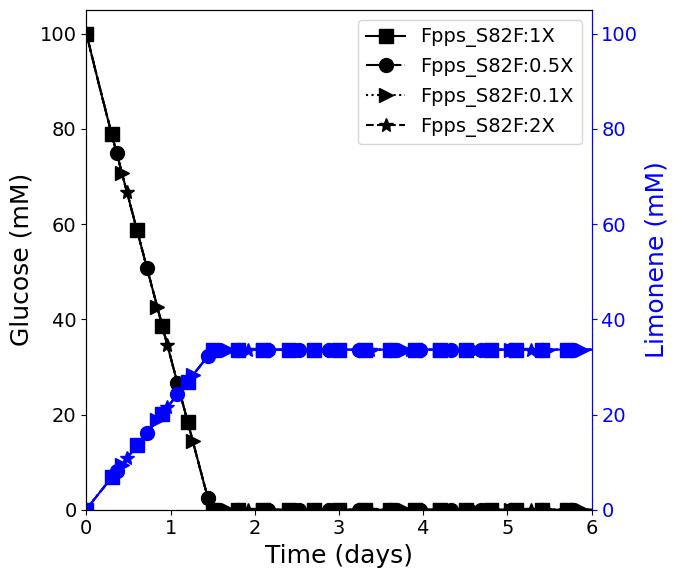

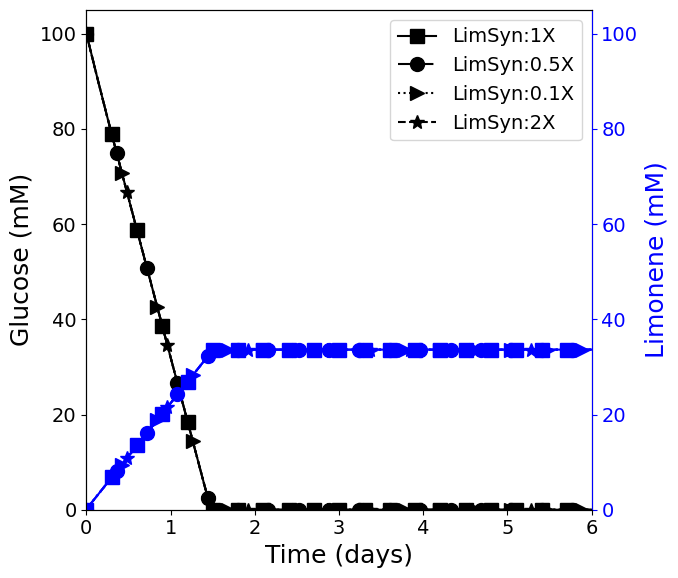

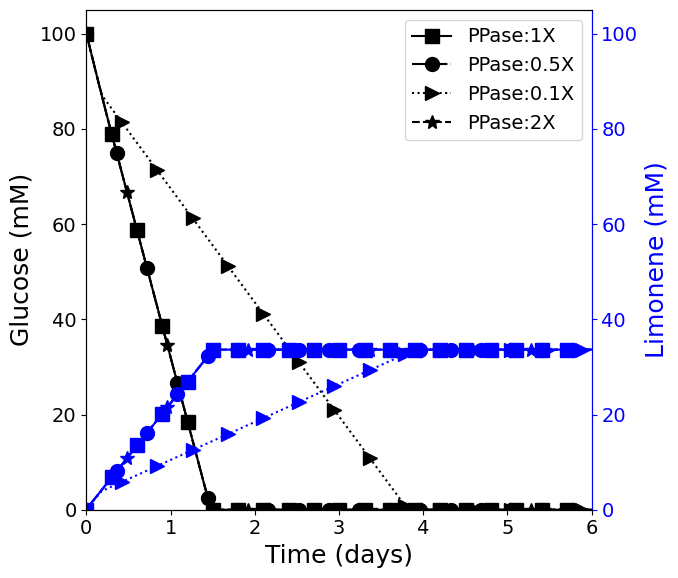

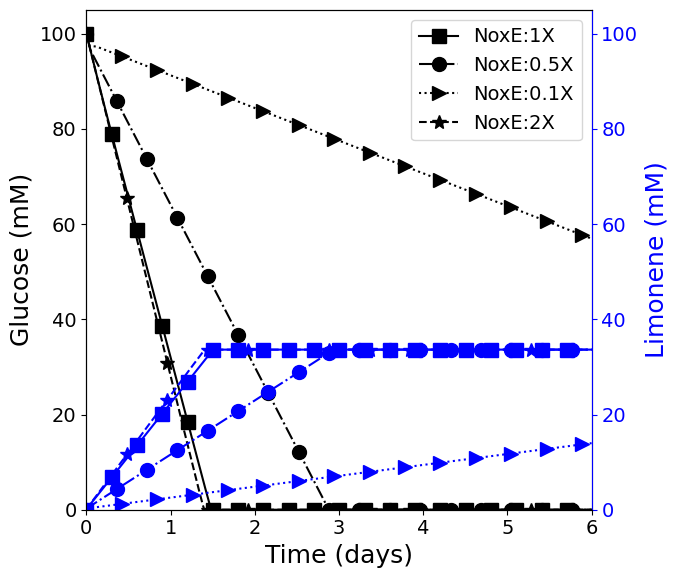

In [14]:
run_sa(save=True)

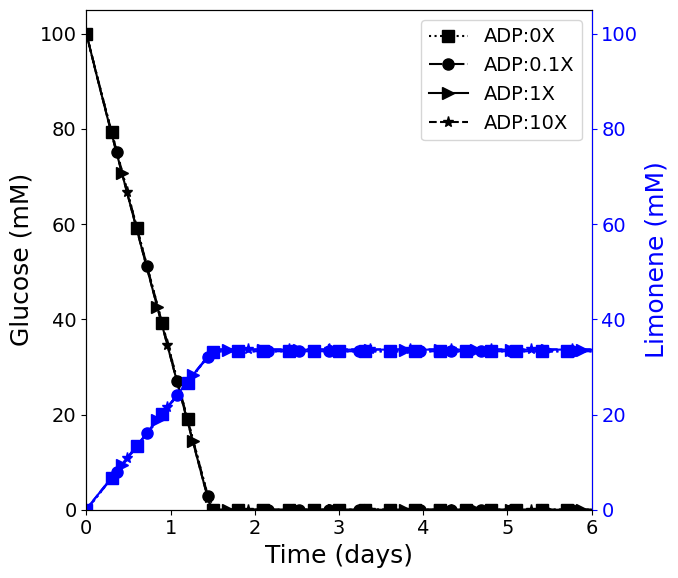

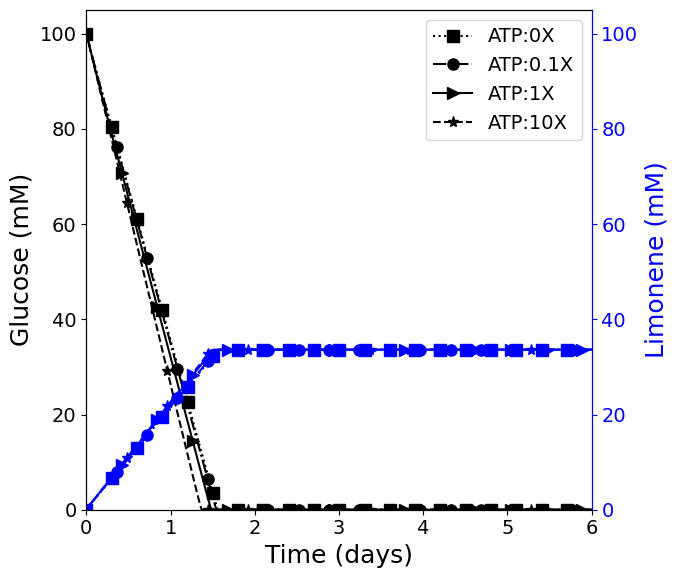

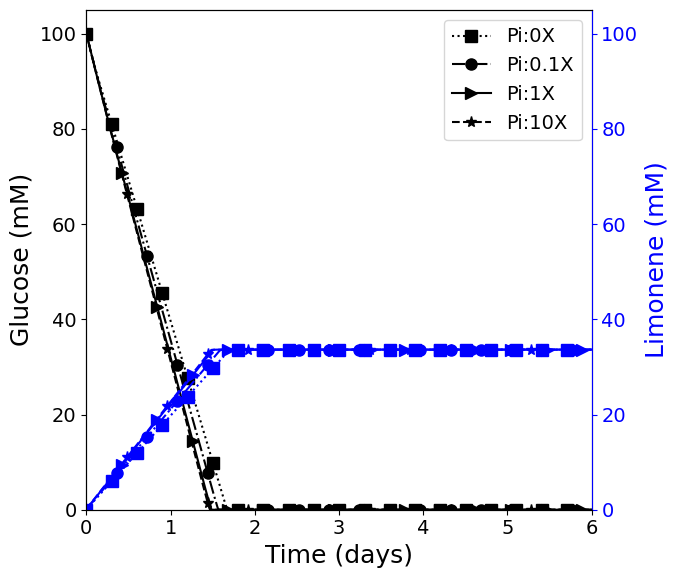

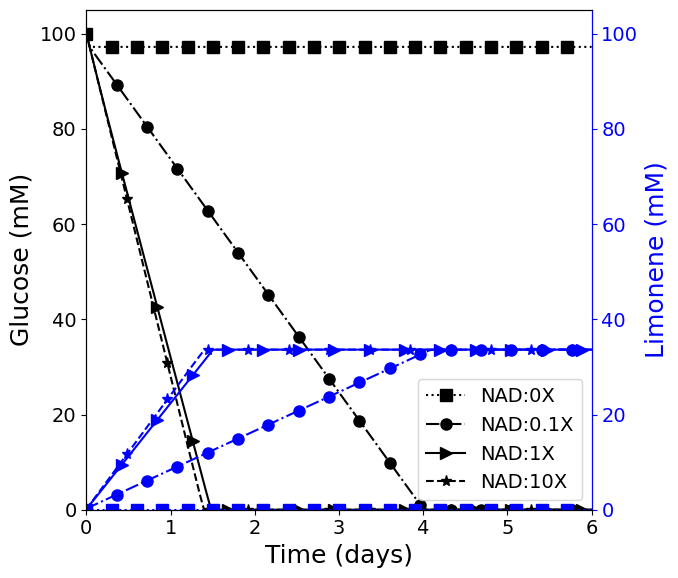

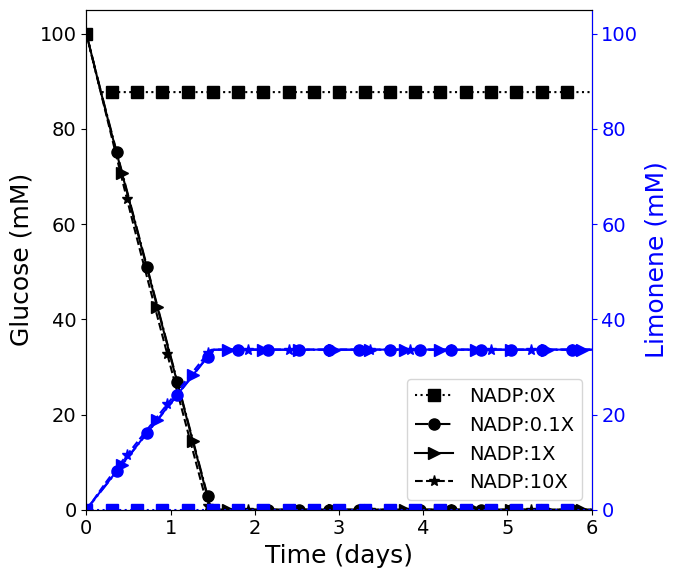

In [15]:
run_cofactor_sa(save=True)